In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt

import numpy as np
import pyemma
import pytraj as pt
import mdtraj as md

from pyemma.util.contexts import settings
from glob import glob

### Loading data

In [2]:
rf0=pt.load('./parm_rst/closed6_dry_rot0.rst7', './parm_rst/closed6_dry_rot0.parm7')
rf1=pt.load('./parm_rst/closed6_dry_rot1.rst7', './parm_rst/closed6_dry_rot1.parm7')
rf2=pt.load('./parm_rst/closed6_dry_rot2.rst7', './parm_rst/closed6_dry_rot2.parm7')
rf3=pt.load('./parm_rst/closed6_dry_rot3.rst7', './parm_rst/closed6_dry_rot3.parm7')
rf4=pt.load('./parm_rst/closed6_dry_rot4.rst7', './parm_rst/closed6_dry_rot4.parm7')
rf5=pt.load('./parm_rst/closed6_dry_rot5.rst7', './parm_rst/closed6_dry_rot5.parm7')

rfopen=pt.load('./parm_rst/open10_dry.rst7', './parm_rst/open10_dry.parm7')

In [3]:
indir = './traj_dry_noeq_without_ipa'
topfile = './parm_rst/open10_dry.parm7'

traj_list = sorted(glob(indir+'/*.nc'))
traj_list

['./traj_dry_noeq_without_ipa/closed_dry_1.nc',
 './traj_dry_noeq_without_ipa/closed_dry_10.nc',
 './traj_dry_noeq_without_ipa/closed_dry_2.nc',
 './traj_dry_noeq_without_ipa/closed_dry_3.nc',
 './traj_dry_noeq_without_ipa/closed_dry_4.nc',
 './traj_dry_noeq_without_ipa/closed_dry_5.nc',
 './traj_dry_noeq_without_ipa/closed_dry_6.nc',
 './traj_dry_noeq_without_ipa/closed_dry_7.nc',
 './traj_dry_noeq_without_ipa/closed_dry_8.nc',
 './traj_dry_noeq_without_ipa/closed_dry_9.nc',
 './traj_dry_noeq_without_ipa/open_dry_1.nc',
 './traj_dry_noeq_without_ipa/open_dry_10.nc',
 './traj_dry_noeq_without_ipa/open_dry_2.nc',
 './traj_dry_noeq_without_ipa/open_dry_3.nc',
 './traj_dry_noeq_without_ipa/open_dry_4.nc',
 './traj_dry_noeq_without_ipa/open_dry_5.nc',
 './traj_dry_noeq_without_ipa/open_dry_6.nc',
 './traj_dry_noeq_without_ipa/open_dry_7.nc',
 './traj_dry_noeq_without_ipa/open_dry_8.nc',
 './traj_dry_noeq_without_ipa/open_dry_9.nc']

### RMSD 'features'

In [4]:
results_open=[]
results_closed=[]
for t in traj_list:
    traj=pt.load(t, topfile)
    rmsd0=pt.rmsd(traj,ref=rf0, mask="@CA,N,C,O")
    rmsd1=pt.rmsd(traj,ref=rf1, mask="@CA,N,C,O")
    rmsd2=pt.rmsd(traj,ref=rf2, mask="@CA,N,C,O")
    rmsd3=pt.rmsd(traj,ref=rf3, mask="@CA,N,C,O")
    rmsd4=pt.rmsd(traj,ref=rf4, mask="@CA,N,C,O")
    rmsd5=pt.rmsd(traj,ref=rf5, mask="@CA,N,C,O")
    
    rmsd_closed=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)
    results_closed.append(rmsd_closed)
    
    rmsd_open=pt.rmsd(traj,ref=rfopen, mask="@CA,N,C,O")
    results_open.append(rmsd_open)

Create a Y matrix similar to that optained with PyEMMA after TICA analysis

In [5]:
Y=[]
for i in range(0,len(results_open)):  
    Z=[]
    for j in range(0,len(results_open[i])):
        a=np.array([results_closed[i][j],results_open[i][j]])
        Z.append(a)
    Z=np.array(Z)
    Y.append(Z)
print(len(Y))
print(len(Y[0]))
print(len(Y[0][0]))

20
48680
2


In [8]:
Y_concat= np.concatenate(Y)

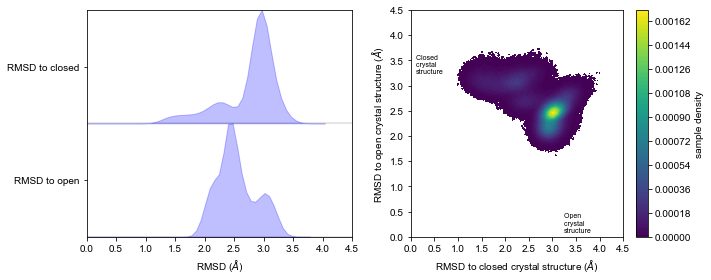

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    Y_concat,
    ax=axes[0],
    feature_labels=[r'RMSD to closed', r'RMSD to open'],
    ylog=False)

axes[0].set_xlabel(r'RMSD ($\AA$)')

axes[0].set(xlim=(0,4.5))

axes[0].set_xticks(np.arange(0, 5, 0.5))

pyemma.plots.plot_density(*Y_concat[:, :2].T, ax=axes[1], logscale=False, nbins=200)

axes[1].text(0.1, 3.2458, "Closed \ncrystal \nstructure", c="black", fontsize=7)
axes[1].text(3.2458, 0.1, "Open \ncrystal \nstructure", c="black", fontsize=7)

axes[1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1].set_ylabel(r'RMSD to open crystal structure ($\AA$)')

axes[1].set(xlim=(0,4.5) , ylim=(0, 4.5))

axes[1].set_xticks(np.arange(0, 5, 0.5))
axes[1].set_yticks(np.arange(0, 5, 0.5))


fig.tight_layout()

In [22]:
n_clustercenters = [10, 100, 200, 500, 1000]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=True):
            _cl = pyemma.coordinates.cluster_kmeans(
                Y, k=k, max_iter=500, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

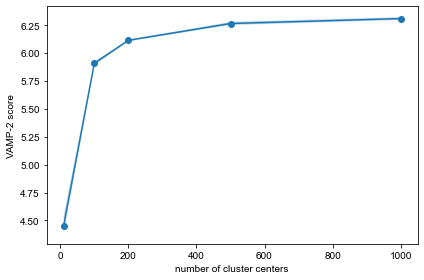

In [24]:
fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
# ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

In [25]:
cluster = pyemma.coordinates.cluster_kmeans(
    Y, k=500, max_iter=500, stride=10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

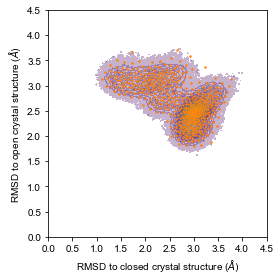

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *Y_concat[:, :2].T, ax=ax, cbar=False, alpha=0.3, nbins=200)
ax.scatter(*cluster.clustercenters[:, :2].T, s=2, c='C1')
ax.set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
ax.set_ylabel(r'RMSD to open crystal structure ($\AA$)')

ax.set(xlim=(0,4.5) , ylim=(0, 4.5))

ax.set_xticks(np.arange(0, 5, 0.5))
ax.set_yticks(np.arange(0, 5, 0.5))
fig.tight_layout()

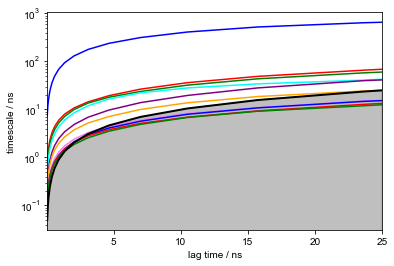

In [48]:
its = pyemma.msm.its(cluster.dtrajs, lags=500, nits=10, errors=None)
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.05, ylog=True);

In [49]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=500, dt_traj='0.05 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

fraction of states used = 1.00
fraction of counts used = 1.00


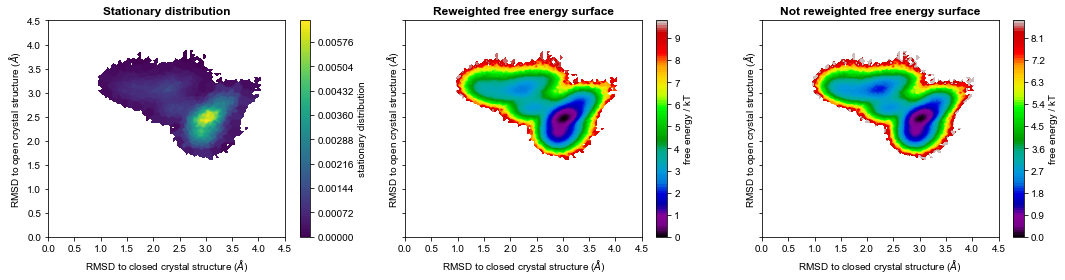

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *Y_concat[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
pyemma.plots.plot_free_energy(
    *Y_concat[:, :2].T,
    weights=None,
    ax=axes[2],
    legacy=False)

axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
axes[2].set_title('Not reweighted free energy surface', fontweight='bold')

axes[0].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[0].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[0].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[0].set_xticks(np.arange(0, 5, 0.5))
axes[0].set_yticks(np.arange(0, 5, 0.5))

axes[1].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[1].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[1].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[1].set_xticks(np.arange(0, 5, 0.5))
axes[1].set_yticks(np.arange(0, 5, 0.5))

axes[2].set_xlabel(r'RMSD to closed crystal structure ($\AA$)')
axes[2].set_ylabel(r'RMSD to open crystal structure ($\AA$)')
axes[2].set(xlim=(0,4.5) , ylim=(0, 4.5))
axes[2].set_xticks(np.arange(0, 5, 0.5))
axes[2].set_yticks(np.arange(0, 5, 0.5))

fig.tight_layout()

The first eigenvector is one: True (min=0.9999999999999953, max=1.0000000000000187)


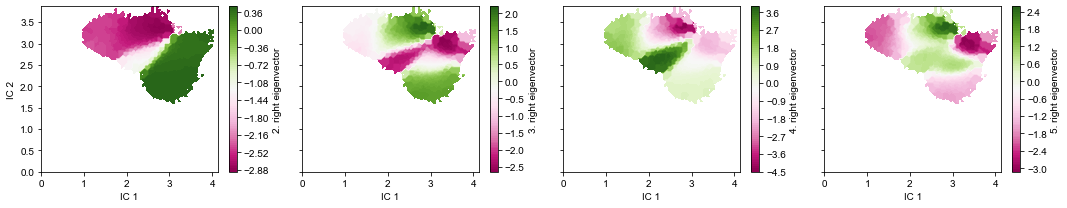

In [53]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *Y_concat[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

In [54]:
msm.pcca(nstates)

PCCA(P=array([[0.00741, 0.     , ..., 0.00012, 0.     ],
       [0.     , 0.01729, ..., 0.     , 0.00076],
       ...,
       [0.00038, 0.     , ..., 0.02379, 0.     ],
       [0.     , 0.00139, ..., 0.     , 0.0155 ]]),
   m=5)

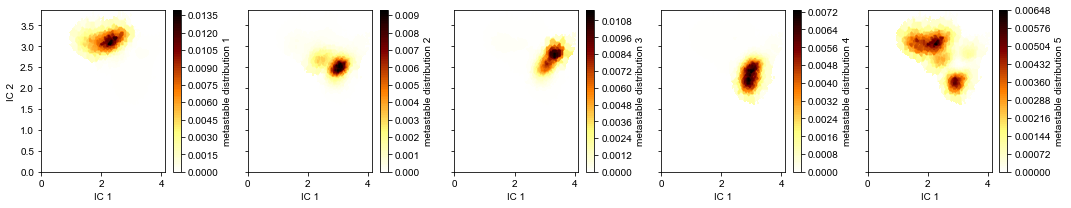

In [59]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *Y_concat[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r', 
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()

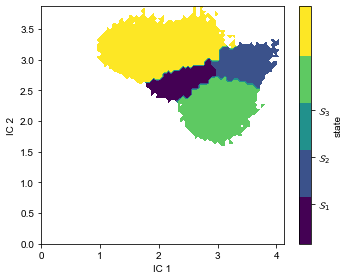

In [57]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *Y_concat[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()